In [216]:
import random
import time

import numpy as np

from matplotlib import pyplot
from matplotlib.colors import Normalize

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Softmax, Reshape
import keras


In [217]:
BOARD_SIZE = 12

# Helpers and stuff

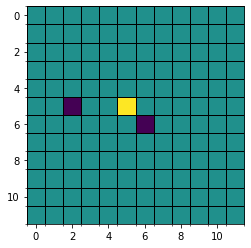

In [218]:
board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

board[5][5][1] = 1
board[6][6][2] = 1
board[2][5][2] = 1

def vis_board(board, shower=pyplot):
    #pyplot.grid(which='minor', color='w', linestyle='-', linewidth=2)
    shower.imshow((board[:,:,1] - board[:,:,2]).transpose(), norm=Normalize(-1 ,1))
    ax = pyplot.gca()

    ax.set_xticks(np.arange(-.5, BOARD_SIZE, 1), minor=True);
    ax.set_yticks(np.arange(-.5, BOARD_SIZE, 1), minor=True);
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    
    #pyplot.axis('off')


vis_board(board)

In [219]:
def get_models():
    move_model = Sequential()
    move_model.add(Conv2D(
        64, kernel_size=3, activation='relu', input_shape=(BOARD_SIZE, BOARD_SIZE, 3), padding='same'
    ))
    move_model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
    #move_model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
    move_model.add(Conv2D(1, kernel_size=3, activation='relu', padding='same'))
    move_model.add(Flatten())
    move_model.add(Softmax())
    move_model.add(Reshape((BOARD_SIZE, BOARD_SIZE, 1)))

    move_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.0001),
        #loss='categorical_crossentropy',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    score_model = Sequential()
    score_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(BOARD_SIZE, BOARD_SIZE, 3)))#, padding='same'))
    score_model.add(Conv2D(64, kernel_size=3, activation='relu')) #, padding='same'))
    #score_model.add(Conv2D(128, kernel_size=3, activation='relu')) #, padding='same'))

    score_model.add(Flatten())

    score_model.add(Dense(32, activation='sigmoid'))
    score_model.add(Dense(10, activation='sigmoid'))
    score_model.add(Dense(1, activation='sigmoid'))

    score_model.compile(
        optimizer=keras.optimizers.Adam(lr=0.0001),
        #loss='categorical_crossentropy',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return move_model, score_model

test_move_model, test_score_model = get_models()

test_move_model.summary()
test_score_model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 12, 12, 64)        1792      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 12, 12, 64)        36928     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 12, 12, 1)         577       
_________________________________________________________________
flatten_19 (Flatten)         (None, 144)               0         
_________________________________________________________________
softmax_10 (Softmax)         (None, 144)               0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 12, 12, 1)         0         
Total params: 39,297
Trainable params: 39,297
Non-trainable params: 0
_________________________________________________

In [220]:
def weighted_random(pairs):
    total = sum(pair[0] for pair in pairs)
    r = random.random() * total # randint(1, total)
    for index, (weight, value) in enumerate(pairs):
        # print('asdf', r, weight)
        r -= weight
        if r <= 0: return index # value
    print('ERROR IN weighted_random')
    return len(pairs) - 1
    return pairs[-1][1]


In [221]:
def augment_data(train_x, train_y, scores):
    augmented_train_x = []
    augmented_train_y = []
    augmented_train_scores = []

    #train_x[0].shape

    #pyplot.imshow(train_x[5].reshape(15, 15))
    #pyplot.imshow(train_y[2].reshape(15, 15))

    #pyplot.imshow(np.flip(np.rot90(train_x[7])).reshape(15, 15))


    for x, y, score in zip(train_x, train_y, scores):
        augmented_train_x.append(x)
        augmented_train_y.append(y)
        augmented_train_scores.append(score)
        augmented_train_x.append(np.rot90(x))
        augmented_train_y.append(np.rot90(y))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.rot90(x, 2))
        augmented_train_y.append(np.rot90(y, 2))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.rot90(x, 3))
        augmented_train_y.append(np.rot90(y, 3))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.flip(x))
        augmented_train_y.append(np.flip(y))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.flip(np.rot90(x)))
        augmented_train_y.append(np.flip(np.rot90(y)))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.flip(np.rot90(x, 2)))
        augmented_train_y.append(np.flip(np.rot90(y, 2)))
        augmented_train_scores.append(score)
        augmented_train_x.append(np.flip(np.rot90(x, 3)))
        augmented_train_y.append(np.flip(np.rot90(y, 3)))
        augmented_train_scores.append(score)
    
    augmented_boards = []
    augmented_statuses = []
    augmented_scores = []
    
    for board, status, score in zip(augmented_train_x, augmented_train_y, augmented_train_scores):
        augmented_boards.append(board)
        augmented_statuses.append(status)
        augmented_scores.append(score)

        flipped_board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))
    
        flipped_board[:,:,0] = 1 if board[0,0,0] == 0 else 0
        flipped_board[:,:,1] = board[:,:,2]
        flipped_board[:,:,2] = board[:,:,1]

        augmented_boards.append(flipped_board)
        augmented_statuses.append(status)
        augmented_scores.append(1 - score)

    
    return np.array(augmented_boards), np.array(augmented_statuses), np.array(augmented_scores)


In [222]:
def filter_by_play_ids(plays, boards, board_statuses, min_play_id):
    from_win = []

    is_first_play = [np.sum(b[:,:,1]) == 0 and np.sum(b[:,:,2]) == 0 for b in boards]

    counter = 0

    for status in is_first_play:
        if status:
            from_win += list(reversed(list(range(counter))))
            counter = 0

        counter += 1
    
    return list(np.array([
        (play, board, status)
        for play, board, status, index in
        zip(plays, boards, board_statuses, from_win)
        if status % 2 == 0 and index <= min_play_id
    ]).transpose())

False

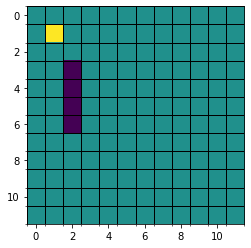

In [223]:
def check_win(board, x, y, player):
    #value = board[x][y][0]
    
    # X direction
    count = 1
    i = 1
    while x - i >= 0 and board[x - i][y][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and board[x + i][y][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Y direction
    count = 1
    i = 1
    while y - i >= 0 and board[x][y - i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while y + i < BOARD_SIZE and board[x][y + i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 1
    count = 1
    i = 1
    while x - i >= 0 and y - i >= 0 and board[x - i][y - i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y + i < BOARD_SIZE and board[x + i][y + i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    # Diagonal 2
    count = 1
    i = 1
    while x - i >= 0 and y + i < BOARD_SIZE and board[x - i][y + i][player+1] == 1:
        count += 1
        i += 1
    i = 1
    while x + i < BOARD_SIZE and y - i >= 0 and board[x + i][y - i][player+1] == 1:
        count += 1
        i += 1
    if count >= 5:
        return True
    
    return False

board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

board[2][3][2] = 1
board[2][4][2] = 1
board[2][5][2] = 1
board[2][6][2] = 1
#board[2][7][2] = 1

board[1][1][1] = 1

vis_board(board)

check_win(board, 2, 5, 1)

In [279]:
EXPANSIONS_PER_MOVE = 500
BOARDS_PER_STEP = 2000

class RootCalculator():
    def __init__(self):
        self.nodes = 0
    
    def expanded(self):
        self.nodes += 1


class TerminalNode():
    def __init__(self, value, xy):
        self.value = value
        self.best_xy = xy
    
    def do_expansion(self, board):
        pass


class Node():
    def __init__(self, board, root_calculator, xy, move_model, score_model, depth):
        self.move_model = move_model
        self.score_model = score_model
        
        self.depth = depth
        self.player = int(board[0][0][0])
        #print('Player is here', self.player)
        self.play_positions = []
        self.sub_nodes = []
        self.play_probs = []
        
        self.expansion_count = 0
        
        self.root_calculator = root_calculator
        self.xy = xy
        self.is_terminal = False
        
        for x in range(BOARD_SIZE):
            for y in range(BOARD_SIZE):
                if board[x][y][1] == 0 and board[x][y][2] == 0:
                    self.play_positions.append((x, y))
        
        if xy == None:
            # Root node
            value = 0.5 # score_model.predict(np.array([board]))[0][0]
        else:
            # Non root
            x, y = xy
            
            board[x][y][self.player + 1] = 1
            
            other_player = 1 if self.player == 0 else 0
            
            if check_win(board, x, y, other_player):
                self.is_terminal = True
                value = other_player
            else:
                value = self.score_model.predict(np.array([board]))[0][0]
            board[x][y][self.player + 1] = 0            
        
        self.value = value
        self.best_xy = xy
    
    def expand(self, board):
        if self.is_terminal:
            return
        
        #best_val = float('inf') if self.player == 0 else float('-inf')
        #best_xy = None
        
        play_probs = self.move_model.predict(np.array([board])).reshape(BOARD_SIZE, BOARD_SIZE)
        
        for x, y in self.play_positions:
            prob = play_probs[x][y]
            self.play_probs.append(prob + 0.1 / (BOARD_SIZE * BOARD_SIZE)) # Add some randomness
            
            #sub_node = Node(board, self.root_calculator, (x, y))
            #self.sub_nodes.append(sub_node)
            
            self.sub_nodes.append(None)
            
            #if (
            #    (self.player == 1 and sub_node.value > best_val) or
            #    (self.player == 0 and sub_node.value < best_val)
            #):
            #    best_val = sub_node.value
            #    best_xy = (x, y)
            
        #self.value = best_val
        #self.best_xy = best_xy
    
    def get_value(self):
        if not any(self.sub_nodes) or self.is_terminal:
            #print('returning self.value', self.value)
            return self.value
        
        value_sums = self.value
        value_count = 1
        
        #best_value = float('inf') if self.player == 0 else float('-inf')
        for node in self.sub_nodes:
            if node:
                node_value = node.get_value()
                value_sums += node_value * (node.expansion_count + 1)
                value_count += (node.expansion_count + 1)
                
                #best_value = min(best_value, node_value) if self.player == 0 else max(best_value, node_value)
        
        return_val = value_sums / value_count
        #print('returning combined value', value_sums, value_count, self.sub_nodes)
        return return_val
        
        #return best_value
    
    def get_best_xy(self):
        
        best_value = float('inf') if self.player == 0 else float('-inf')
        best_xy = None
        
        for xy, node in zip(self.play_positions, self.sub_nodes):
            if node is not None:
                node_value = node.get_value()
                #print('asdf', xy, node_value, best_value, best_xy)
                if (self.player == 0 and node_value < best_value) or (self.player == 1 and node_value > best_value):
                    best_value = node_value
                    best_xy = xy
        
        return best_xy
    
    def get_sub_node_at(self, xy):
        for pos, sub_node in zip(self.play_positions, self.sub_nodes):
            if sub_node and xy == pos:
                return sub_node
        raise ValueError('Invalid path')
        
    def get_values_rec(self, path=[]):
        if path:
            return self.get_sub_node_at(path[0]).get_values_rec(path[1:])
        
        values = np.ones((BOARD_SIZE, BOARD_SIZE)) * -1

        for (x, y), sub_node in zip(self.play_positions, self.sub_nodes):
            if sub_node:
                sub_node_value = sub_node.get_value()
                #print('asdf', sub_node_value)
                values[x][y] = sub_node_value

        return values

    
    def do_expansion(self, board):
        self.expansion_count += 1
        
        self.root_calculator.expanded()
        
        
        if self.sub_nodes:
            # Select expansion position
            random_node_index = weighted_random(list(zip(self.play_probs, self.sub_nodes)))
            random_node = self.sub_nodes[random_node_index]
            random_node_xy = self.play_positions[random_node_index]
            
            x, y = random_node_xy
            board[x][y][self.player + 1] = 1
            board[:,:,0] = 1 if self.player == 0 else 0
            #board[x][y][self.player + 1] = 0
            #board[:,:,0] = self.player

            # Expand or add random node
            if random_node is None:
                xy = self.play_positions[random_node_index]
                random_node = Node(
                    board, 
                    self.root_calculator,
                    random_node_xy,
                    self.move_model,
                    self.score_model,
                    self.depth+1
                )
                self.sub_nodes[random_node_index] = random_node
                value = random_node.value
            else:
                random_node.do_expansion(board)
                value = random_node.value
                
            board[x][y][self.player + 1] = 0
            board[:,:,0] = self.player
            
            '''
            # Update value
            if self.player == 1:
                if value > self.value or self.best_xy == None:
                    self.best_xy = random_node_xy
                    #print('Updating bestxy', self.xy, self.best_xy, self.depth)
                    self.value = value
                #self.value = max(value, self.value)
            else:
                if value < self.value or self.best_xy == None:
                    self.best_xy = random_node_xy
                    #print('Updating bestxy', self.xy, self.best_xy, self.depth)
                    self.value = value
                #self.value = min(value, self.value)
            '''
            
            #all_sub_values = [sub_node.value for sub_node in self.sub_nodes if sub_node]
            #self.value = sum(all_sub_values) / len(all_sub_values)
            
        else:
            self.expand(board)


def do_play_round(move_model, score_model):
    boards = []
    plays = []
    board_statuses = []

    while True:
        batch_boards = []
        batch_plays = []
        batch_board_stauts = []

        board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

        winned = False

        for i in range(int(BOARD_SIZE * BOARD_SIZE / 2)): # Max board size / 2 so no stupid board filling games allowed
            #print('Starting loop')
            cur_player = int(board[0][0][0])

            root_calculator = RootCalculator()
            node = Node(board, root_calculator, None, move_model, score_model,0)
            for i in range(EXPANSIONS_PER_MOVE):
                node.do_expansion(board)
                #print('wtf', node.best_xy)
                #print('node_count', root_calculator.nodes)
            #print('asdfg', node.best_xy, node.depth)
            x, y = node.get_best_xy()

            batch_boards.append(board.copy())
            play_pos = np.zeros((BOARD_SIZE, BOARD_SIZE, 1))
            play_pos[x][y][0] = 1
            batch_plays.append(play_pos)

            board[x][y][cur_player + 1] = 1

            if check_win(board, x, y, cur_player):
                print('Win condition found')
                winned = True
                batch_board_stauts = len(batch_boards) * [cur_player]
                break

            board[:,:,0] = 1 if cur_player == 0 else 0 # Change the current player

        if winned:
            boards += batch_boards
            plays += batch_plays
            board_statuses += batch_board_stauts

        print('Loop ended', len(boards), len(plays), len(board_statuses))
        
        if len(boards) > BOARDS_PER_STEP:
            return boards, plays, board_statuses


def run_simulation():
    move_model, score_model = get_models()
    
    prev_augmented_boards, prev_augmented_plays, prev_augmented_board_statuses = (
        np.array([]).reshape(0, BOARD_SIZE, BOARD_SIZE, 3),
        np.array([]).reshape(0, BOARD_SIZE, BOARD_SIZE, 1),
        np.array([]).reshape(0)
    )
    
    loop_index = 0
    while True:
        boards, plays, board_statuses = do_play_round(move_model, score_model)

        np.savez_compressed(
            'game_data/loop_{}_game_data'.format(loop_index),
            plays=plays, 
            boards=boards,
            board_statuses=board_statuses
        )

        move_model.save('game_data/loop_{}_move_model.h5'.format(loop_index))
        score_model.save('game_data/loop_{}_score_model.h5'.format(loop_index))

        move_model, score_model = get_models()
        
        # Only winners and only latest if we are on earlier rounds
        f_plays, f_boards, f_board_statuses = filter_by_play_ids(plays, boards, board_statuses, int(loop_index / 2))
        
        augmented_boards, augmented_plays, augmented_board_statuses = augment_data(f_boards, f_plays, f_board_statuses)
        
        history = score_model.fit(
            np.concatenate((prev_augmented_boards, augmented_boards)),
            np.concatenate((prev_augmented_board_statuses, augmented_board_statuses)),
            epochs=20,
            #validation_split=0.2,
            shuffle=True
        )
        history = move_model.fit(
            np.concatenate((prev_augmented_boards, augmented_boards)),
            np.concatenate((prev_augmented_plays, augmented_plays)),
            epochs=20,
            #validation_split=0.2,
            shuffle=True
        )
        
        prev_augmented_boards, prev_augmented_plays, prev_augmented_board_statuses = augmented_boards, augmented_plays, augmented_board_statuses

        loop_index += 1
    

#run_simulation()

In [146]:
print('Running simulation')
run_simulation()

Running simulation
Win condition found
Loop ended 58 58 58
Win condition found
Loop ended 93 93 93
Win condition found
Loop ended 133 133 133
Win condition found
Loop ended 179 179 179
Win condition found
Loop ended 245 245 245
Loop ended 245 245 245
Win condition found
Loop ended 298 298 298
Win condition found
Loop ended 332 332 332
Win condition found
Loop ended 376 376 376
Win condition found
Loop ended 429 429 429
Win condition found
Loop ended 468 468 468
Win condition found
Loop ended 523 523 523
Epoch 1/20
64/64 [==============================] - 0s 4ms/step - loss: 0.7156 - accuracy: 0.5000
Epoch 2/20
64/64 [==============================] - 0s 453us/step - loss: 0.7125 - accuracy: 0.5000
Epoch 3/20
64/64 [==============================] - 0s 502us/step - loss: 0.7093 - accuracy: 0.5000
Epoch 4/20
64/64 [==============================] - 0s 439us/step - loss: 0.7058 - accuracy: 0.5000
Epoch 5/20
64/64 [==============================] - 0s 467us/step - loss: 0.7021 - accuracy: 

KeyboardInterrupt: 

In [ ]:
#thing = np.array([[1,2], [2,3], [3,4]])
#print(thing.shape)

#np.concatenate((np.array([]).reshape(0, 2), thing))

In [ ]:
# plays.shape

#boards.shape, plays.shape, board_statuses.shape

In [ ]:
#a_boards, a_plays, a_board_statues = augment_data(boards, plays, board_statuses)

In [ ]:
#a_boards[51][:,:,1]

# Analyzing the data

In [225]:
! ls -lha game_data



total 7208
drwxr-xr-x   9 osku  staff   288B Feb 10 18:27 .
drwxr-xr-x  22 osku  staff   704B Feb 10 19:27 ..
drwxr-xr-x   2 osku  staff    64B Feb 10 10:51 .ipynb_checkpoints
-rw-r--r--   1 osku  staff   108K Feb 10 18:27 loop_0_game_data.npz
-rw-r--r--   1 osku  staff   173K Feb 10 18:27 loop_0_move_model.h5
-rw-r--r--   1 osku  staff   686K Feb 10 18:27 loop_0_score_model.h5
-rw-r--r--   1 osku  staff    96K Feb 10 18:27 loop_1_game_data.npz
-rw-r--r--   1 osku  staff   490K Feb 10 18:27 loop_1_move_model.h5
-rw-r--r--   1 osku  staff   2.0M Feb 10 18:27 loop_1_score_model.h5


In [226]:
board_i = 1

score_model = keras.models.load_model('game_data/loop_{board_i}_score_model.h5'.format(board_i=board_i))
move_model = keras.models.load_model('game_data/loop_{board_i}_move_model.h5'.format(board_i=board_i))

loaded = np.load('game_data/loop_{board_i}_game_data.npz'.format(board_i=board_i))
list(loaded.keys())
plays = loaded['plays']
boards = loaded['boards']
board_statuses = loaded['board_statuses']

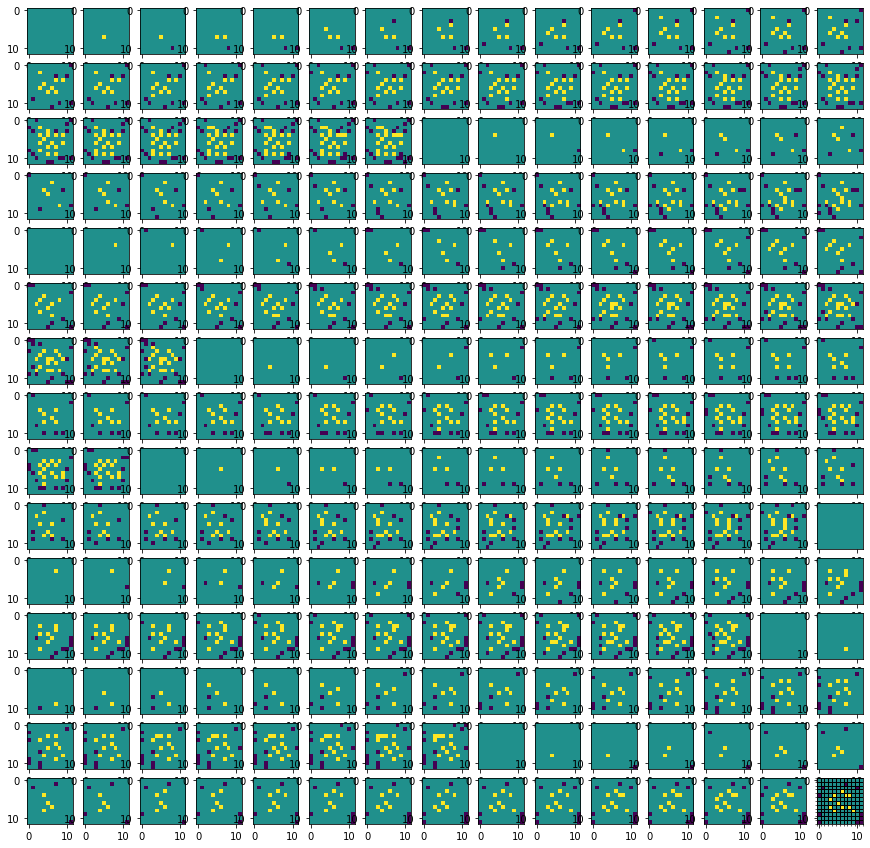

In [227]:
fig, axs = pyplot.subplots(15, 15, figsize=(15, 15))
i = 0
for x in range(15):
    for y in range(15):
        if not i >= len(boards):
            vis_board(boards[i], axs[x][y])
            #axs[x * 2 + 1][y].imshow(plays[i].reshape(12, 12).transpose())
            #print(board_statuses[i], boards[i][0][0][0])
        i += 1

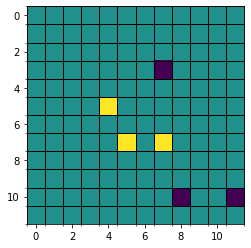

In [228]:
board_i = 6

vis_board(boards[board_i])

(0.027336322, 0.27847585)

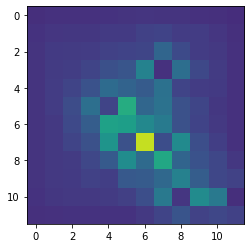

In [229]:
prediction = move_model.predict(np.array([boards[board_i]])).reshape(BOARD_SIZE, BOARD_SIZE)
score_prediction = score_model.predict(np.array([boards[board_i]]))


pyplot.imshow(
    prediction.transpose(),
    norm=Normalize(0, 0.03)
)

np.max(prediction), score_prediction[0][0]

In [230]:
win_stats = []
game_len_stats = []

board_i = 0
while True:
    try:
        loaded = np.load('game_data/loop_{board_i}_game_data.npz'.format(board_i=board_i))
    except FileNotFoundError:
        break
    
    win_stats.append(np.sum(loaded['board_statuses']) / len(loaded['board_statuses']))
    
    game_starts = sum([np.sum(board[:,:,1]) == 0 and np.sum(board[:,:,2]) == 0 for board in loaded['boards']])
    game_len_stats.append(len(loaded['boards']) / game_starts)
    
    board_i += 1
    if board_i > 100:
        break
        
win_stats, game_len_stats

([0.6147101802240623, 0.14583333333333334],
 [39.48076923076923, 32.516129032258064])

(0, 1)

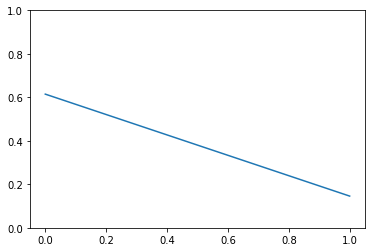

In [231]:
pyplot.plot(win_stats)
pyplot.ylim((0,1))

(0, 100)

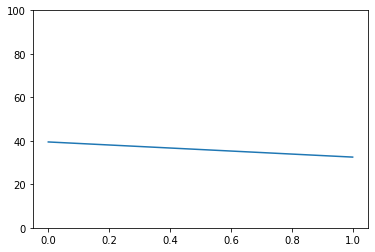

In [232]:
pyplot.plot(game_len_stats)
pyplot.ylim((0, 100))

# Other stuff

# Stuff

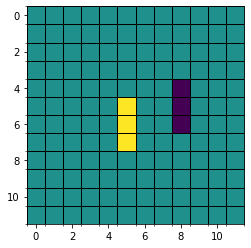

In [302]:
board = np.zeros((BOARD_SIZE, BOARD_SIZE, 3))

board[5][5][1] = 1
board[5][6][1] = 1
board[5][7][1] = 1
#board[5][8][1] = 1

board[8][4][2] = 1
board[8][5][2] = 1
board[8][6][2] = 1
#board[8][7][2] = 1

board[:,:,0] = 1

vis_board(board)

In [329]:
root_calculator = RootCalculator()
node = Node(board, root_calculator, None, move_model, score_model, 0)
for i in range(100000):
    node.do_expansion(board)


In [330]:
#node.xy

In [331]:
#node.get_sub_node_at((8, 3)).xy

In [332]:
#node.get_sub_node_at((8, 3)).get_sub_node_at((8, 7)).xy

(0.030689528, 0.74420315)

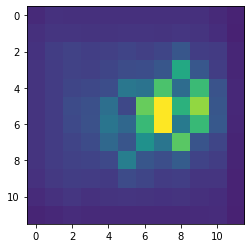

In [333]:
prediction = move_model.predict(np.array([board])).reshape(BOARD_SIZE, BOARD_SIZE)
score_prediction = score_model.predict(np.array([board]))


pyplot.imshow(
    prediction.transpose(),
    norm=Normalize(0, 0.03)
)

np.max(prediction), score_prediction[0][0]

(11, 8)

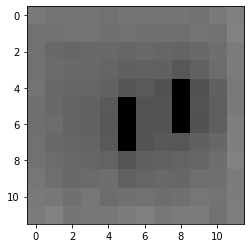

In [334]:
values = node.get_values_rec([])
pyplot.imshow(values.transpose(), norm=Normalize(0, 1), cmap='gray')
node.get_best_xy()

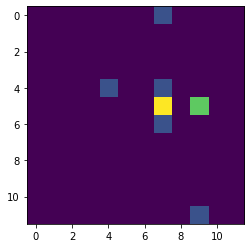

In [335]:
values = np.zeros((BOARD_SIZE, BOARD_SIZE))
for sub_node in node.get_sub_node_at((8, 3)).get_sub_node_at((6, 5)).sub_nodes:
    if sub_node:
        values[sub_node.xy[0]][sub_node.xy[1]] = sub_node.expansion_count
pyplot.imshow(values.transpose())

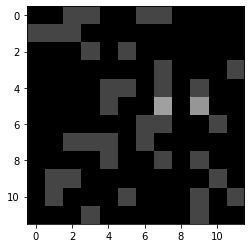

In [336]:
values = node.get_values_rec([(8, 3), (6, 5)])
pyplot.imshow(values.transpose(), norm=Normalize(0, 1), cmap='gray')

In [337]:
values.transpose()

array([[-1.        , -1.        ,  0.27192736,  0.27185103, -1.        ,
        -1.        ,  0.27175981,  0.27173442, -1.        , -1.        ,
        -1.        , -1.        ],
       [ 0.27212882,  0.27182546,  0.27116585, -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        ,  0.26951852, -1.        ,
         0.26920357, -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        ,  0.26926199, -1.        , -1.        ,
        -1.        ,  0.27166766],
       [-1.        , -1.        , -1.        , -1.        ,  0.2683934 ,
         0.26888353, -1.        ,  0.26937512, -1.        ,  0.27016625,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        ,  0.2688722 ,
        -1.        , -

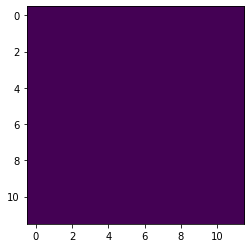

In [338]:
#pyplot.imshow(values.transpose(), norm=Normalize(np.min(values), np.max(values)), cmap='bwr')
pyplot.imshow(values.transpose() == 1)# , cmap='gray')

In [339]:
node.get_best_xy()

(11, 8)

(0.030689528, 0.0028759341, 0.74420315)

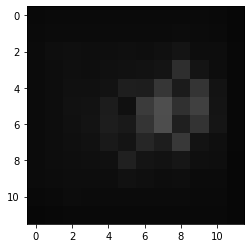

In [340]:
prediction = move_model.predict(np.array([board])).reshape(BOARD_SIZE, BOARD_SIZE)
score_prediction = score_model.predict(np.array([board]))


pyplot.imshow(
    prediction.transpose(),
    norm=Normalize(0, 0.1),
    cmap='gray'
)

np.max(prediction), np.min(prediction), score_prediction[0][0]